
# EDA de ofertas Relámpago — Presentación

**Objetivo:**  
Explorar y entender el comportamiento de las ofertas relámpago, detectar patrones de éxito y oportunidades, y evaluar posibles problemas de integridad de datos.

**Estructura:**  
1. Visión general  
2. Patrones clave de las ofertas  
3. Errores y anomalías encontradas  
4. Conclusiones y próximos pasos


In [11]:
# Core data libraries
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../../src')

from DFutils import VisualizationUtils

# Statistical
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import f_oneway

In [12]:
# Notebook display options
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

In [13]:
# Seaborn style for presentation
sns.set_theme(
    style="whitegrid",          # clean background with grid
    palette="viridis",          # nice color palette
    font_scale=1.2              # larger fonts for presentations
)

# Matplotlib tweaks for cleaner look
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.edgecolor"] = "0.3"
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

## 1. Visión general

In [14]:
df_all = pd.read_parquet('../../data/01_processed/ofertas_relampago.parquet')

In [15]:
total_offers = len(df_all)
with_sales = (df_all["SOLD_QUANTITY"] > 0).sum()
without_sales = total_offers - with_sales
pct_sales = with_sales / total_offers * 100

print(f"Total de ofertas: {total_offers:,}")
print(f"Con ventas: {with_sales:,} ({pct_sales:.1f}%)")
print(f"Sin ventas: {without_sales:,} ({100-pct_sales:.1f}%)")

df_all.describe(include="all").T


Total de ofertas: 48,746
Con ventas: 24,579 (50.4%)
Sin ventas: 24,167 (49.6%)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
OFFER_START_DATE,48746,NaN,NaN,NaN,2021-07-05 11:24:49.008328704,2021-06-01 00:00:00,2021-06-22 00:00:00,2021-07-07 00:00:00,2021-07-21 00:00:00,2021-07-31 00:00:00,NaN
OFFER_START_DTTM,48746,NaN,NaN,NaN,2021-07-06 00:35:32.408813056+00:00,2021-06-01 07:00:00+00:00,2021-06-22 15:00:00+00:00,2021-07-07 18:00:00+00:00,2021-07-21 12:00:00+00:00,2021-07-31 19:00:00+00:00,NaN
OFFER_FINISH_DTTM,48746,NaN,NaN,NaN,2021-07-06 06:18:02.448713984+00:00,2021-06-01 07:00:00+00:00,2021-06-22 21:22:13+00:00,2021-07-08 00:00:00+00:00,2021-07-21 15:03:39.750000128+00:00,2021-08-01 03:00:00+00:00,NaN
INVOLVED_STOCK,"48,746.00",NaN,NaN,NaN,35.01,1.00,5.00,10.00,15.00,"9,000.00",206.76
REMAINING_STOCK_AFTER_END,"48,746.00",NaN,NaN,NaN,30.57,-192.00,4.00,8.00,15.00,"8,635.00",195.81
SOLD_AMOUNT,"24,579.00",NaN,NaN,NaN,51.21,0.28,5.73,12.42,30.93,"4,836.57",175.25
SOLD_QUANTITY,"24,579.00",NaN,NaN,NaN,10.85,1.00,1.00,3.00,6.00,"1,646.00",45.48
ORIGIN,48746,2,Otros,37430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SHIPPING_PAYMENT_TYPE,48746,2,free_shipping,26658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOM_DOMAIN_AGG1,48746,36,HOME&DECOR,6742,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Patrones clave de las ofertas

C:\Users\leand\AppData\Local\Temp\ipykernel_37812\3079378323.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


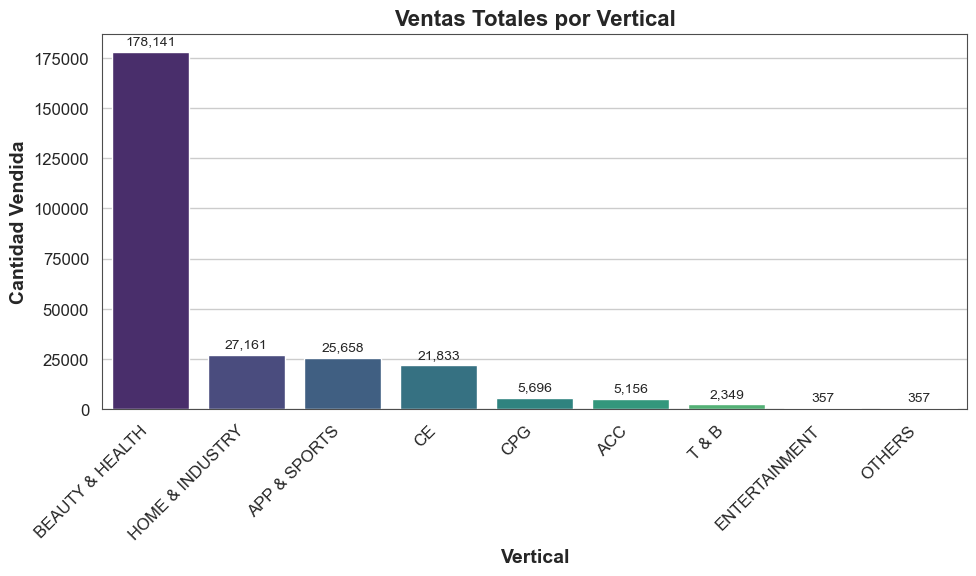

In [16]:
ventas_vertical = (df_all
                   .groupby("VERTICAL", as_index=False)["SOLD_QUANTITY"]
                   .sum()
                   .sort_values("SOLD_QUANTITY", ascending=False))

ax = sns.barplot(data=ventas_vertical, x="VERTICAL", y="SOLD_QUANTITY",hue='VERTICAL', legend=False,palette='viridis')
ax.set_title("Ventas Totales por Vertical")
ax.set_xlabel("Vertical")
ax.set_ylabel("Cantidad Vendida")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
VisualizationUtils.add_bar_labels(ax)
plt.tight_layout()
plt.show()

In [17]:
df_all.groupby('DOMAIN_ID').agg(
    {'SOLD_QUANTITY':'sum','SOLD_AMOUNT':'sum'}).reset_index().sort_values(by='SOLD_AMOUNT',ascending=False)

,DOMAIN_ID,SOLD_QUANTITY,SOLD_AMOUNT
1094,MLM-SURGICAL_AND_INDUSTRIAL_MASKS,"141,369.00","410,363.30"
239,MLM-CELLPHONES,"1,769.00","111,678.79"
1131,MLM-TELEVISIONS,451.00,"66,366.08"
369,MLM-DISPOSABLE_GLOVES,"13,477.00","55,365.39"
589,MLM-HEADPHONES,"4,447.00","29,628.06"
...,...,...,...
816,MLM-MOTORCYCLE_TRANSMISSION_KITS,0.00,0.00
263,MLM-CHOCOLATE_WATERFALLS,0.00,0.00
808,MLM-MOTORCYCLE_GOGGLES,0.00,0.00
264,MLM-CHOPSTICKS,0.00,0.00


## Como Beauty & Health tiene una grande distinction de los demás Se va hacer un teste de hipotesis

In [19]:
df_offer = pd.read_parquet('../../data/01_processed/ofertas_relampago.parquet')

df_offer = df_offer.loc[df_offer["SOLD_QUANTITY"].notnull()].reset_index(drop = True).copy()

In [20]:
# Grupos para ANOVA
groups = [df_offer.loc[df_offer["VERTICAL"] == v, "SOLD_QUANTITY"]
          for v in df_offer["VERTICAL"].unique()]

In [21]:
f_stat, p_anova = f_oneway(*groups)
print(f"[ANOVA] F={f_stat:.2f}, p-value={p_anova:.3e}")

[ANOVA] F=310.74, p-value=0.000e+00


### El ANOVA previo mostró que las medias de ventas por vertical no son iguales (p < 0.05), lo que justifica el análisis post-hoc.

In [22]:
# Post-hoc: Tukey HSD (qué pares difieren)
tukey = pairwise_tukeyhsd(endog=df_offer["SOLD_QUANTITY"],
                          groups=df_offer["VERTICAL"],
                          alpha=0.05)

c:\Users\leand\anaconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [23]:
tukey_df = pd.DataFrame(tukey.summary().data[1:], columns=tukey.summary().data[0])
display(tukey_df.sort_values("p-adj").head(15))

,group1,group2,meandiff,p-adj,lower,upper,reject
17,BEAUTY & HEALTH,ENTERTAINMENT,-38.23,0.00,-48.50,-27.95,True
1,ACC,BEAUTY & HEALTH,36.29,0.00,32.06,40.52,True
20,BEAUTY & HEALTH,T & B,-37.22,0.00,-42.44,-32.00,True
19,BEAUTY & HEALTH,OTHERS,-37.23,0.00,-49.72,-24.74,True
8,APP & SPORTS,BEAUTY & HEALTH,36.37,0.00,33.76,38.98,True
18,BEAUTY & HEALTH,HOME & INDUSTRY,-35.18,0.00,-37.91,-32.45,True
16,BEAUTY & HEALTH,CPG,-35.51,0.00,-39.88,-31.15,True
15,BEAUTY & HEALTH,CE,-35.41,0.00,-38.25,-32.57,True
12,APP & SPORTS,HOME & INDUSTRY,1.19,0.86,-1.28,3.66,False
34,HOME & INDUSTRY,T & B,-2.04,0.95,-7.19,3.11,False


<b> BEAUTY & HEALTH sobresale significativamente sobre casi todas las demás verticales: </b>
- Ventas promedio 36–38 unidades más que ACC y APP & SPORTS.
- Diferencias grandes también frente a CPG, T & B, OTHERS, HOME & INDUSTRY, y ENTERTAINMENT.
- Todas estas diferencias son estadísticamente significativas (p-ajustado < 0.001).

C:\Users\leand\AppData\Local\Temp\ipykernel_37812\334468096.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


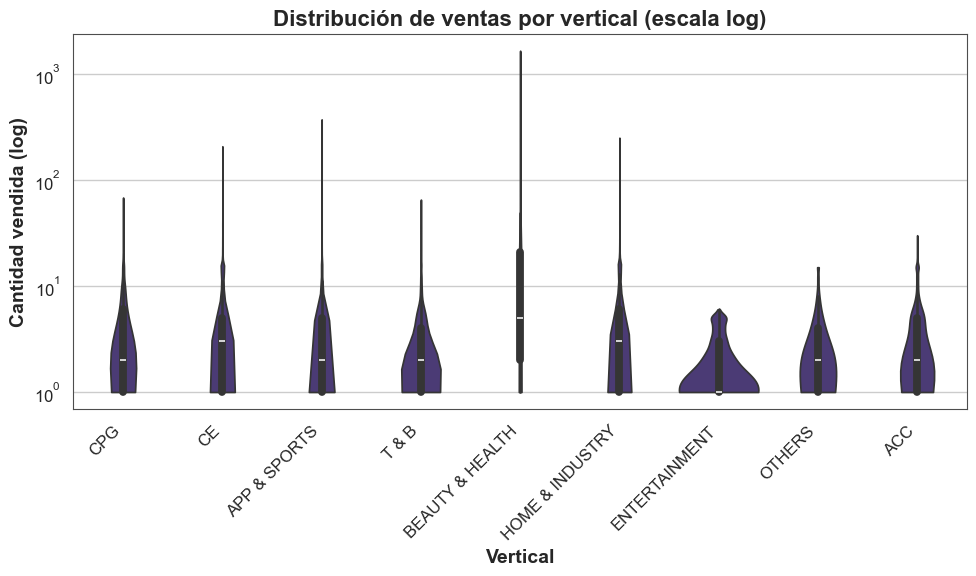

In [24]:
# Visual: violines en log (mejor legibilidad con sesgo y outliers)
ax = sns.violinplot(
    data=df_offer, x="VERTICAL", y="SOLD_QUANTITY",
    inner="box", cut=0
)

ax.set_yscale("log")
ax.set_title("Distribución de ventas por vertical (escala log)")
ax.set_xlabel("Vertical")
ax.set_ylabel("Cantidad vendida (log)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()

<b> BEAUTY & HEALTH es claramente la vertical más efectiva en ventas absolutas, con diferencias estadísticamente y prácticamente significativas sobre la mayoría de las demás. </b>
- El resto de verticales muestran desempeños más parecidos entre sí, con algunas diferencias puntuales pero de menor magnitud.
- La alta dispersión sugiere que, incluso en verticales “débiles”, existen oportunidades aisladas con ventas muy altas (productos nicho de gran éxito).

C:\Users\leand\AppData\Local\Temp\ipykernel_37812\3315607653.py:8: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=df_all, x="VERTICAL", y="DURATION_HOURS", order=order,
C:\Users\leand\AppData\Local\Temp\ipykernel_37812\3315607653.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


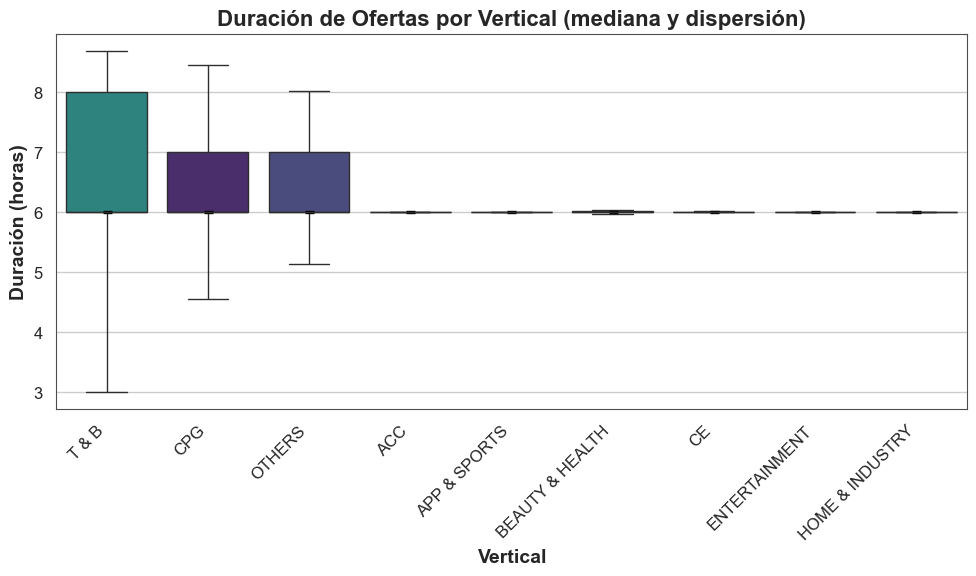

In [25]:
# Ordenar verticales por mediana de duración
order = (df_all.groupby("VERTICAL")["DURATION_HOURS"]
         .median()
         .sort_values(ascending=False)
         .index)

ax = sns.boxplot(data=df_all, x="VERTICAL", y="DURATION_HOURS",hue='VERTICAL', legend=False,palette='viridis', order=order, showfliers=False)
sns.pointplot(data=df_all, x="VERTICAL", y="DURATION_HOURS", order=order,
              estimator="median", errorbar=None, color="black", markers="_", linestyles="", scale=1.2)
ax.set_title("Duración de Ofertas por Vertical (mediana y dispersión)")
ax.set_xlabel("Vertical")
ax.set_ylabel("Duración (horas)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


<b> Todas las verticales estan con las duraciones entre 6 horas pero algunas como: </b>
- T & B, OTHERS y CPG tienes mucho mas range de intento de tanto extension como diminuir la duraccion de las ofertas

C:\Users\leand\AppData\Local\Temp\ipykernel_37812\3523023218.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(t*100)}%" for t in ax.get_yticks()])
C:\Users\leand\AppData\Local\Temp\ipykernel_37812\3523023218.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


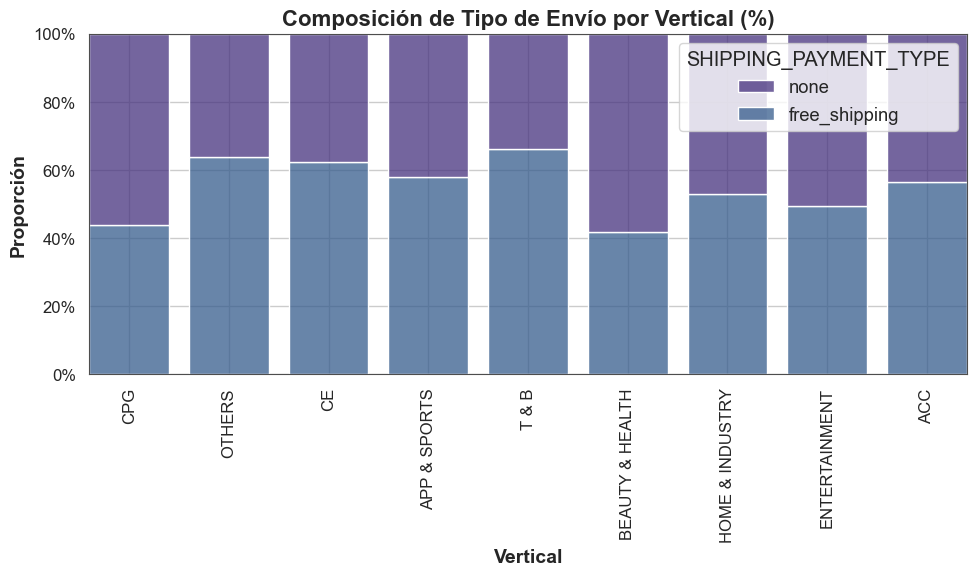

In [26]:
# Stacked-normalized look using histplot (percentage per vertical)
ax = sns.histplot(data=df_all, x="VERTICAL", hue="SHIPPING_PAYMENT_TYPE",
                  multiple="fill", stat="probability", shrink=0.8, discrete=True)
ax.set_title("Composición de Tipo de Envío por Vertical (%)")
ax.set_xlabel("Vertical")
ax.set_ylabel("Proporción")
ax.set_yticklabels([f"{int(t*100)}%" for t in ax.get_yticks()])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()


<b> Se podrá ver que Se tienen una bueña distribuicion de los produtos con free shipping y sin free shipping </b>
- La categoria de beauty & Health contiene menos free shippnig que las otras
- T & B contiene mucho más que las otras

## 3. Errores y anomalías encontradas

In [28]:
df_mov = pd.read_parquet('../../data/01_processed/ofertas_relampago_sin_ventas_stock_movimentado.parquet')
df_no_mov = pd.read_parquet('../../data/01_processed/ofertas_relampago_sin_ventas_stock_no_movimentado.parquet')

In [29]:
# Flag: movimiento de stock sin ventas
mov_sin_ventas = len(df_mov)
no_mov_sin_ventas = len(df_no_mov)

# Duración rara
dur_hours = df_all["DURATION_HOURS"]
duracion_rara = ((dur_hours <= 0) | (dur_hours > 24*30)).sum()

# Stock negativo
stock_negativo = (df_all["REMAINING_STOCK_AFTER_END"] < 0).sum()

pd.DataFrame({
    "Tipo de anomalía": [
        "Movimiento de stock sin ventas",
        "Sin movimiento y sin ventas",
        "Duración atípica",
        "Stock final negativo"
    ],
    "Casos": [mov_sin_ventas, no_mov_sin_ventas, duracion_rara, stock_negativo]
})


,Tipo de anomalía,Casos
0,Movimiento de stock sin ventas,588
1,Sin movimiento y sin ventas,23579
2,Duración atípica,1314
3,Stock final negativo,1273


### Conclusión
- <b> Beauty & Health presenta un rendimiento significativamente superior en ventas respecto a la mayoría de las demás verticales.
- Varias verticales muestran desempeños similares entre sí, sin diferencias estadísticamente significativas.
- Existe alta variabilidad interna en todas las verticales, lo que sugiere oportunidades de mejora incluso en las menos efectivas.

### Próximos pasos
- <b> Profundizar en Beauty & Health </b> para identificar los factores detrás de su alta conversión (precio, promociones, características del producto, tipo de cliente).
- <b> Replicar mejores prácticas </b> detectadas en Beauty & Health en otras verticales con bajo rendimiento.
- <b> Segmentar por producto </b> dentro de cada vertical para encontrar “hidden winners” que puedan escalarse.
- <b> Evaluar campañas piloto </b> con ajustes estratégicos (p. ej., Tipo de envío, duración de oferta) en verticales de bajo desempeño.